
# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 3: Neural Machine Translation (30 pts)
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder (18 pts)

In [1]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/2020.1011/HW/HW2/Answer/answer-part3/

/content/drive/.shortcut-targets-by-id/1lw8YIdTE5p10TT6vMJ--f5lc1ycU0hJv/2020.1011/HW/HW2/Answer/answer-part3


In [3]:
relative_path = './'

In [4]:
# Add utilities path
import sys

path_to_utils = relative_path + 'pyfiles'
sys.path.append(path_to_utils)
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 './pyfiles']

In [5]:
# Import custom modules
import global_variables
import nmt_dataset
import nnet_models_new

global_variables.device

device(type='cuda')

In [6]:
import torch

torch.__version__

'1.7.0+cu101'

In [7]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = relative_path+'.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = relative_path+'./data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [8]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [9]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64

In [10]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [11]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
enc_layers = 1
lr = 0.025;
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 20

#### 1.1 Encoder (9 pts)

Positional Encoding reference:

> [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

> [SEQUENCE-TO-SEQUENCE MODELING WITH NN.TRANSFORMER AND TORCHTEXT](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

In [12]:
import torch.nn as nn
from torch.autograd import Variable

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # print(x.size(), x.dtype)
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        # print(x.dtype)
        return self.dropout(x)

cf.

> `register_buffer`: Adds a buffer to the module that should not to be considered a model parameter. 

> `Variable`: This class was used to create tensors that support gradient calculations and operation tracking. Deprecated from v0.4.0, and merged with `torch.Tensor`

In [13]:
import math

class EncoderTransformer(nn.Module):
    def __init__(self, vocab_size, max_len, dim=8, num_layers=1, nhead=2, dropout=0.0):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, dim)
        self.position_embed = PositionalEncoding(d_model=dim, dropout=dropout, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead, dim_feedforward=64, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # self.projection = nn.Linear(dim, vocab_size)
    
    def features(self, token_indices):
        # pos = torch.arange(len(token_indices), device=token_indices.device).unsqueeze(1)
        x = self.token_embed(token_indices)
        x = self.position_embed(x).transpose(0,1)
        x = self.encoder(x)
        return x
    
    def forward(self, token_indices):
        x = self.features(token_indices) #length x batch x dim
        # x = self.projection(x)
        return x.transpose(0,1), x.sum(dim=0, keepdim=True)

In [14]:
encoder_transformer = EncoderTransformer(vocab_size=source_vocab, max_len=MAX_LEN, dim=hidden_size, num_layers=enc_layers, nhead=2, dropout=0.1)
encoder_transformer

EncoderTransformer(
  (token_embed): Embedding(12392, 512)
  (position_embed): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

Issues/mistakes #1
- 

#### 1.2 Decoder(s) (9 pts)

In [15]:
# Basic RNN decoder (no attention)
decoder_rnn = nnet_models_new.DecoderRNN(target_vocab, hidden_size, numlayers=1)

decoder_rnn

DecoderRNN(
  (embedding): Embedding(20111, 512)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [16]:
nmt_dflt = nnet_models_new.seq2seq(encoder_transformer, decoder_rnn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
#                               numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
nmt_dflt

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(20111, 512)
    (gru): GRU(512, 512, batch_first=True

In [17]:
# Basic RNN decoder (no attention) - II
encoder_attention = False
self_attention = False

decoder_noattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)
decoder_noattn

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(512, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [18]:
nmt_noattn = nnet_models_new.seq2seq(encoder_transformer, decoder_noattn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
#                               numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
nmt_noattn

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(512, 512)

In [19]:
# RNN Decoder with Encoder attention
encoder_attention = True
self_attention = False

decoder_encattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)
decoder_encattn

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(1024, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=1)
  (encoder_attention_module): Attention_Module(
    (l1): Linear(in_features=512, out_features=512, bias=False)
    (l2): Linear(in_features=1024, out_features=512, bias=False)
  )
)

In [20]:
nmt_encattn = nnet_models_new.seq2seq(encoder_transformer, decoder_encattn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
#                               numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
nmt_encattn

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512

In [21]:
# RNN Decoder with Self attention
encoder_attention = False
self_attention = True

decoder_selfattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)
decoder_selfattn

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(512, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=1)
  (projector_summ): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
nmt_selfattn = nnet_models_new.seq2seq(encoder_transformer, decoder_selfattn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
#                               numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
nmt_selfattn

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(512, 512)

In [23]:
# RNN Decoder with Encoder & Self attention
encoder_attention = True
self_attention = True

decoder_enc_selfattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)
decoder_enc_selfattn

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(1024, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=1)
  (projector_summ): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (encoder_attention_module): Attention_Module(
    (l1): Linear(in_features=512, out_features=512, bias=False)
    (l2): Linear(in_features=1024, out_features=512, bias=False)
  )
)

In [24]:
nmt_enc_selfattn = nnet_models_new.seq2seq(encoder_transformer, decoder_enc_selfattn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
#                               numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
nmt_enc_selfattn

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512

Enhancements
- Loop through decoders

Issues/Mistakes
- Instantiating encoder class for every model

#### Training & Evaluation

In [25]:
import time

In [26]:
def get_full_filepath(path, dec_type):
    filename = 'nmt_enc_transfomer_'+dec_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

In [27]:
def save_models(nmt_model, path, dec_type):
    if not os.path.exists(path):
            os.makedirs(path)
    torch.save(nmt_model, get_full_filepath(path, dec_type))

In [28]:
from tqdm import notebook#.tqdm

def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', dec_type ='dflt'):

    best_bleu = -1
    train_loss_cache = []
    val_bleu_cache = []
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train'])
        train_loss_cache.append(epoch_loss) 
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        # sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score, '\n')
            # sys.stdout.flush()
            val_bleu_cache.append(val_bleu_score)
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, dec_type);

        # print('='*50)

    torch.save({
        # 'options': options,
        # 'model_state': nmt.state_dict(),
        'train_loss_cache': train_loss_cache,
        'val_bleu_cache': val_bleu_cache
    }, get_full_filepath(saved_model_path, dec_type)[:-4]+'-plot_cache.pt')

    print('='*50)
    print("Training completed. Best BLEU is {}".format(best_bleu))

In [29]:
# Basic RNN decoder (no attention)
train_again = False
dec_type = 'dflt'
if os.path.exists(get_full_filepath(saved_models_dir, dec_type)) and (not train_again):
    nmt_dflt = torch.load(get_full_filepath(saved_models_dir, dec_type), map_location=global_variables.device)
    print(nmt_dflt)
else:
    train_model(dataloader_dict, eval('nmt_'+ dec_type), 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      dec_type = dec_type)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(20111, 512)
    (gru): GRU(512, 512, batch_first=True

In [30]:
# Basic RNN decoder (no attention) - II
train_again = False
dec_type = 'noattn'
if os.path.exists(get_full_filepath(saved_models_dir, dec_type)) and (not train_again):
    nmt_noattn = torch.load(get_full_filepath(saved_models_dir, dec_type), map_location=global_variables.device)
    print(nmt_noattn)
else:
    train_model(dataloader_dict, eval('nmt_'+ dec_type), 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      dec_type = dec_type)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(512, 512)

In [31]:
# RNN Decoder with Encoder attention
train_again = False
dec_type = 'encattn'
if os.path.exists(get_full_filepath(saved_models_dir, dec_type)) and (not train_again):
    nmt_encattn = torch.load(get_full_filepath(saved_models_dir, dec_type), map_location=global_variables.device)
    print(nmt_encattn)
else:
    train_model(dataloader_dict, eval('nmt_'+ dec_type), 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      dec_type = dec_type)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512

In [32]:
# RNN Decoder with Self attention
train_again = False
dec_type = 'selfattn'
if os.path.exists(get_full_filepath(saved_models_dir, dec_type)) and (not train_again):
    nmt_selfattn = torch.load(get_full_filepath(saved_models_dir, dec_type), map_location=global_variables.device)
    print(nmt_selfattn)
else:
    train_model(dataloader_dict, eval('nmt_'+ dec_type), 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      dec_type = dec_type)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(512, 512)

In [33]:
# RNN Decoder with Encoder & Self attention
train_again = False
dec_type = 'enc_selfattn'
if os.path.exists(get_full_filepath(saved_models_dir, dec_type)) and (not train_again):
    nmt_enc_selfattn = torch.load(get_full_filepath(saved_models_dir, dec_type), map_location=global_variables.device)
    print(nmt_enc_selfattn)
else:
    train_model(dataloader_dict, eval('nmt_'+ dec_type), 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      dec_type = dec_type)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512

In [34]:
# Basic RNN decoder (no attention) - II - Old
encoder_attention = False
self_attention = False

decoder_noattn_old = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)
decoder_noattn_old

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(512, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [35]:
nmt_noattn_old = nnet_models_new.seq2seq(encoder_transformer, decoder_noattn_old,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
#                               numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
nmt_noattn_old

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(512, 512)

In [36]:
# Basic RNN decoder (no attention) - II - Old
train_again = False
dec_type = 'noattn_old'
if os.path.exists(get_full_filepath(saved_models_dir, dec_type)) and (not train_again):
    nmt_noattn_old = torch.load(get_full_filepath(saved_models_dir, dec_type), map_location=global_variables.device)
    print(nmt_noattn_old)
else:
    train_model(dataloader_dict, eval('nmt_'+ dec_type), 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      dec_type = dec_type)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(512, 512)

In [37]:
# RNN Decoder with Encoder attention - old
encoder_attention = True
self_attention = False

decoder_encattn_old = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)
decoder_encattn_old

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(1024, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=1)
  (encoder_attention_module): Attention_Module(
    (l1): Linear(in_features=512, out_features=512, bias=False)
    (l2): Linear(in_features=1024, out_features=512, bias=False)
  )
)

In [38]:
nmt_encattn_old = nnet_models_new.seq2seq(encoder_transformer, decoder_encattn_old,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
#                               numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
nmt_encattn_old

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512

In [ ]:
# RNN Decoder with Encoder attention - old
train_again = True
dec_type = 'encattn_old'
if os.path.exists(get_full_filepath(saved_models_dir, dec_type)) and (not train_again):
    nmt_encattn_old = torch.load(get_full_filepath(saved_models_dir, dec_type))
    print(nmt_encattn_old)
else:
    train_model(dataloader_dict, eval('nmt_'+ dec_type), 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      dec_type = dec_type)

Epoch: [0/20]



epoch 0 loss = 3.8528460456393763, time = 744.7103605270386
validation bleu:  0.0 

Epoch: [1/20]



epoch 1 loss = 3.796380609026246, time = 738.1447479724884
validation bleu:  0.0 

Epoch     2: reducing learning rate of group 0 to 2.5000e-02.
Epoch: [2/20]



epoch 2 loss = 3.5391908203135567, time = 754.1552832126617
validation bleu:  0.0 

Epoch     3: reducing learning rate of group 0 to 2.5000e-03.
Epoch: [3/20]



epoch 3 loss = 3.4994727738346088, time = 744.6428942680359
validation bleu:  0.0 

Epoch     4: reducing learning rate of group 0 to 2.5000e-04.
Epoch: [4/20]



epoch 4 loss = 3.505711191578915, time = 739.6305773258209
validation bleu:  0.0 

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [5/20]



epoch 5 loss = 3.493222389723125, time = 733.2811114788055
validation bleu:  0.0 

Epoch: [6/20]


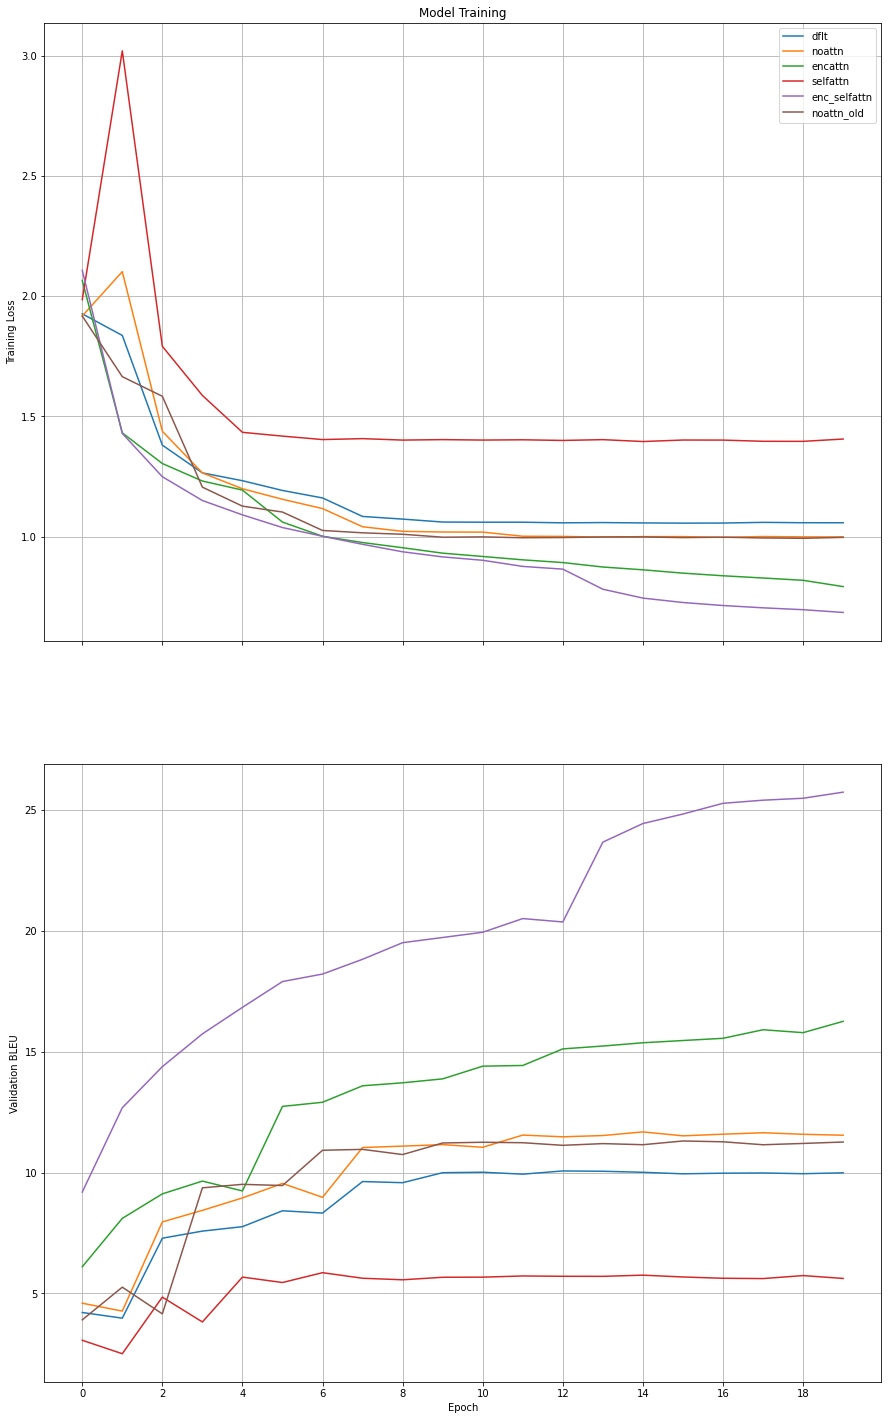

In [43]:
# Plot
import matplotlib.pyplot as plt

nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1, figsize = (15, 25), sharex='col')#, sharey='row')
plt_title = 'Model Training'

models = ['dflt','noattn','encattn','selfattn','enc_selfattn', 'noattn_old']
for model_suffix in models:
  model_file = get_full_filepath(saved_models_dir, model_suffix)[:-4]+'-plot_cache.pt'
  model_dict = torch.load(model_file)

  ax[0].plot(model_dict['train_loss_cache'], label=model_suffix)
  ax[1].plot(model_dict['val_bleu_cache'], label=model_suffix)


ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Validation BLEU')

ax[0].legend(loc='best')
ax[1].set_xlabel('Epoch')

for i in range(nrows):
  ax[i].set_xticks(range(0, num_epochs, 2))
  ax[i].grid()

ax[0].set_title(plt_title)

plt.show()

---
### 2 Attention visualization (12 pts)

Model was trained in ~2 hours, i.e. you can expect attention maps to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [39]:
!pip install googletrans

from googletrans import Translator
translator = Translator()

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 983kB 10.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=f429a598e0f8e7441b0869a5a3088094dd7397c33f3684d1d6eb8d34f55988f9
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=41d8e7efb91e18643f0ce78ac273a976147387a5a0a16e66fc75b4c8be1b2e38
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [46]:
import numpy as np
from collections import namedtuple
import matplotlib.ticker as ticker

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = global_variables.device # torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure() # fig = plt.figure(figsize = (18,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ') +
                       [global_variables.EOS_TOKEN]); # fontsize=10

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def get_translation(nmt_model, sentence, lang_obj, use_cuda):

    print('source: ', sentence)
    # print('GT on sentence (src->tgt): ', translator.translate(sentence, 
    #                                                  src = source_name,
    #                                                  dest = target_name).text)
    
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    if prediction:
      print('\nprediction: ', prediction)
      # print('GT on prediction (tgt->src): ', translator.translate(prediction, 
      #                                                             src = target_name,
      #                                                             dest = source_name).text
      #      )
    else:
      print('\nprediction: <None>')

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [47]:
def print_outputs(sentence):
  for model_suffix in models:
    mdl_str = 'Model: ' + model_suffix
    print(mdl_str)
    print('-'*len(mdl_str))

    get_translation(eval('nmt_' + model_suffix), sentence, source_lang_obj, use_cuda)

    print('='*50, '\n')

Model: dflt
-----------
source:  hello how are you ?

prediction:  les choses sont faites !

Model: noattn
-------------
source:  hello how are you ?

prediction:  oui je vous ai fait .

Model: encattn
--------------
source:  hello how are you ?

prediction:  en avez vous termine ?


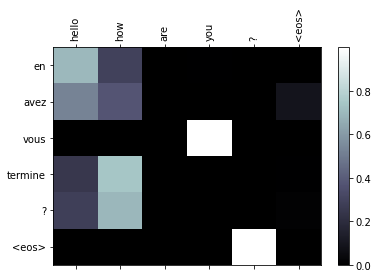


Model: selfattn
---------------
source:  hello how are you ?

prediction:  je te prie de faire une autre .

Model: enc_selfattn
-------------------
source:  hello how are you ?

prediction:  comment allez vous ?


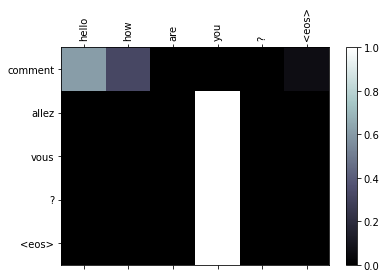


Model: noattn_old
-----------------
source:  hello how are you ?

prediction:  avez vous de l air d une assurance ?



In [48]:
print_outputs('hello how are you ?')

3388 Source:  her smile expressed her thanks .  Target:  son sourire exprimait sa gratitude . 

Model: dflt
-----------
source:  her smile expressed her thanks .

prediction:  son pere est mort .

Model: noattn
-------------
source:  her smile expressed her thanks .

prediction:  sa robe ne s est pas mal .

Model: encattn
--------------
source:  her smile expressed her thanks .

prediction:  ils l ont fait pleurer .


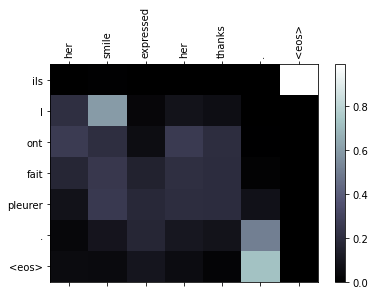


Model: selfattn
---------------
source:  her smile expressed her thanks .

prediction:  je sais ce qu elle a achete son pere .

Model: enc_selfattn
-------------------
source:  her smile expressed her thanks .

prediction:  son sourire a l air en train de se faire sourire .


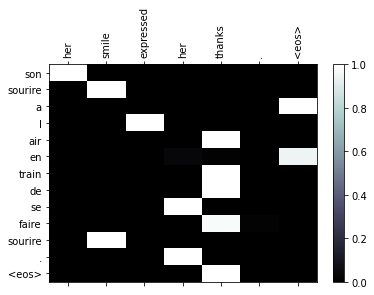


Model: noattn_old
-----------------
source:  her smile expressed her thanks .

prediction:  elle a fait de l exercice .



In [49]:
sample_idx = np.random.choice(range(len(dataset_dict['val'])))
sentence = source_lang_obj.vec2txt(dataset_dict['val'][sample_idx][0])
print(sample_idx, 'Source: ', sentence, ' Target: ', target_lang_obj.vec2txt(dataset_dict['val'][sample_idx][1]),'\n')
print_outputs(sentence)